In [23]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
# import torch
# import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

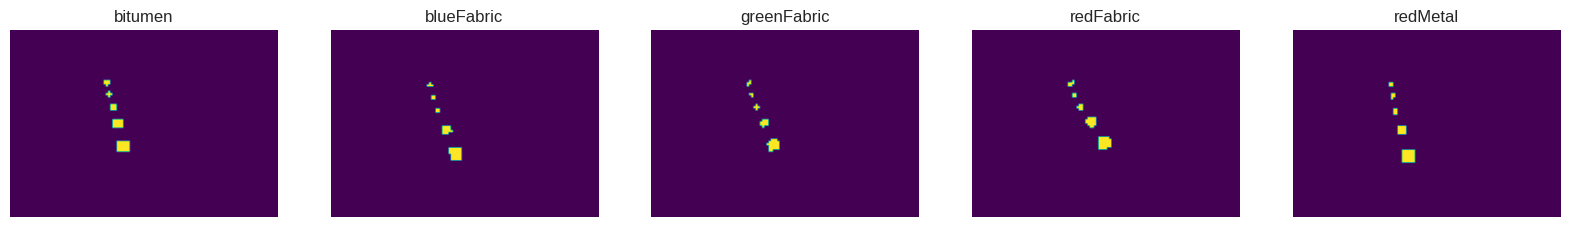

In [24]:
PATH = '/home/abian/Data/Dataset/HSI/DLR_HySU/DLR_HySU/Matlab/'

import scipy.io as sio
A = sio.loadmat(PATH+'A.mat')

material = list(A.keys())[3:]

plt.figure(figsize=(20,10))
for i in range(len(material)):
    plt.subplot(2,5,i+1)
    plt.imshow(A[material[i]], cmap='viridis')
    plt.axis('off')
    plt.title(material[i])

plt.show()

(-0.5, 85.5, 122.5, -0.5)

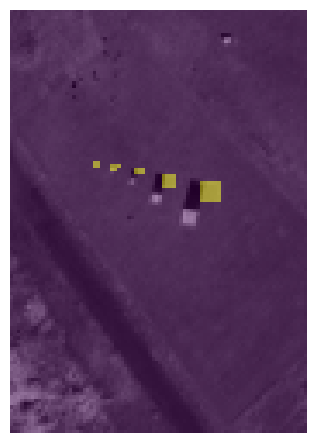

In [25]:
mat = sio.loadmat(PATH+'full.mat')
keys = list(mat.keys())[3:]

X = mat[keys[0]]
wv = mat[keys[1]]

plt.imshow(X[:,:,100].T, cmap='gray')
plt.imshow(A['redMetal'].T, cmap='viridis', alpha=0.5)
plt.axis('off')

In [26]:
import pandas as pd
csv = pd.read_csv(PATH+'DLR_HySU_SVC_ASCII.csv')

signatures = csv.iloc[:, 1:7].to_numpy()
print(signatures.max())
signatures = signatures / (signatures.max() + 1e-3)
material = csv.columns[1:7]

FileNotFoundError: [Errno 2] No such file or directory: '/home/abian/Data/Dataset/HSI/DLR_HySU/DLR_HySU/Matlab/DLR_HySU_SVC_ASCII.csv'

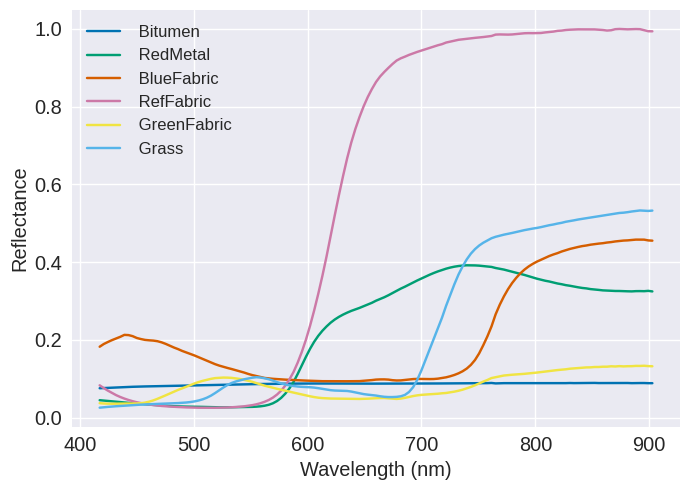

In [ ]:
from utils import plot_endmembers

fig = plot_endmembers(signatures.T, wv.reshape(-1)*1e3, material)
plt.show()

In [ ]:
mat = sio.loadmat(PATH+'full.mat')
X = mat['X'] / (mat['X'].max() + 1e-3)
original_shape = X.shape
X = X.reshape(-1, X.shape[-1])

from HySpecLab.eea import VCA
n_endmembers = 6

vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=128)
vca.fit(X)
E = vca.endmembers()
# endmember_init = torch.from_numpy(vca.endmembers()).float()

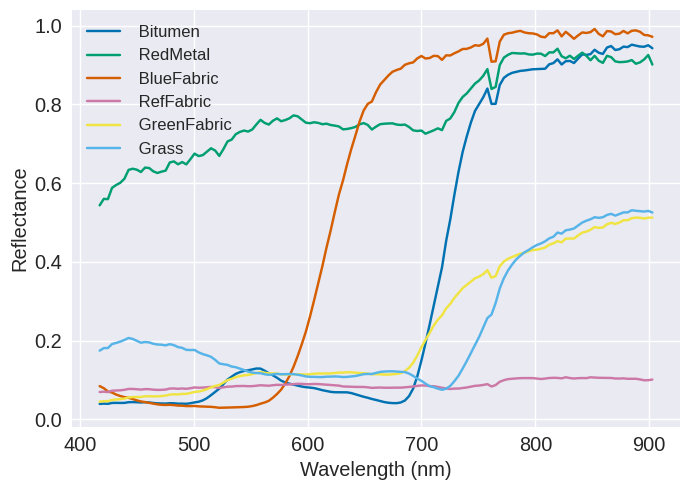

In [ ]:
fig = plot_endmembers(E, wv.reshape(-1)*1e3, material)
# plt.show().shape

In [ ]:
print(signatures.T.shape, E.shape)

(6, 135) (6, 135)


In [ ]:
from HySpecLab.metrics import sad
import torch
_signatures = torch.from_numpy(signatures.T).float()
_E = torch.from_numpy(E).float()

sad_result = sad(_signatures, _E)


idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
sad_result, idx

(tensor([[0.7770, 0.1067, 0.6104, 0.0972, 0.6062, 0.5734],
         [0.5390, 0.4889, 0.1164, 0.5268, 0.4107, 0.6037],
         [0.4132, 0.4780, 0.5766, 0.4743, 0.3254, 0.0564],
         [0.4957, 0.5455, 0.0194, 0.5815, 0.3792, 0.5752],
         [0.5233, 0.2786, 0.5660, 0.2830, 0.3771, 0.3398],
         [0.0739, 0.6115, 0.4450, 0.6373, 0.1323, 0.3655]]),
 tensor([3, 2, 5, 2, 1, 0]))

In [ ]:
# Urban dataset
class Urban(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(Urban, self).__init__()

        data = sio.loadmat(os.path.join(root_dir, 'Urban_R162.mat'))
        y = sio.loadmat(os.path.join(root_dir, 'groundTruth/end4_groundTruth.mat'))
        # y = sio.loadmat(os.path.join(root_dir, 'groundTruth_Urban_end5/end5_groundTruth.mat'))


        self.n_row, self.n_col , self.n_bands = data['nRow'].item(), data['nCol'].item(), data['nBand'].item()

        self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_endmembers = self.E.shape[0]
        
        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.reshape(self.n_row, self.n_col, -1)

In [ ]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

In [27]:
from scipy import io as sio
import os
data_jr = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
gt_jr = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'GroundTruth/end4.mat'))

In [28]:
data_jr.keys(), gt_jr.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'Region', 'SlectBands', 'nRow', 'nCol', 'nBand', 'Y', 'maxValue']),
 dict_keys(['__header__', '__version__', '__globals__', 'cood', 'M', 'A']))

In [29]:
data_jr['Y'].shape, data_jr['nRow'], data_jr['nCol']

((198, 10000), array([[100]], dtype=uint8), array([[100]], dtype=uint8))

In [35]:
DLR_HySU_PATH = '/home/abian/Data/Dataset/HSI/DLR_HySU/DLR_HySU/Matlab/'

data = sio.loadmat(os.path.join(DLR_HySU_PATH, 'full.mat'))
data['X'].shape
n_row, n_col, n_bands = data['X'].shape


In [39]:
my_data = {}
my_data['Y'] = data['X'].reshape(-1, n_bands)
my_data['nRow'] = n_row
my_data['nCol'] = n_col
my_data['nBand'] = n_bands
my_data['maxValue'] = data['X'].max()


sio.savemat(os.path.join(DLR_HySU_PATH, 'full.mat'), my_data)

In [55]:
masks = sio.loadmat(os.path.join(DLR_HySU_PATH, 'masks.mat'))
print(masks.keys())
masks['targetsROI'].shape

dict_keys(['__header__', '__version__', '__globals__', 'materials', 'targetsROI'])


(86, 123)

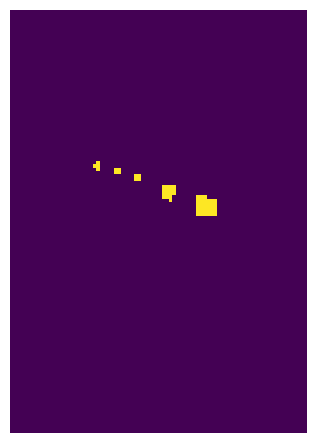

In [71]:
plt.imshow(masks['materials'][:,:,2].T, cmap='viridis')
plt.axis('off')
plt.show()

dict_keys(['__header__', '__version__', '__globals__', 'bitumen', 'blueFabric', 'greenFabric', 'redFabric', 'redMetal'])


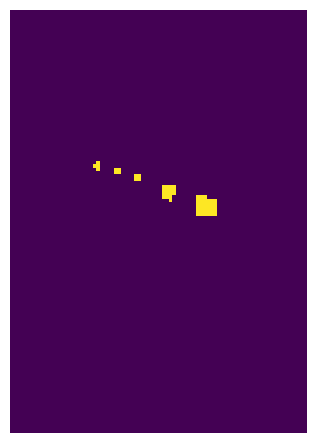

In [90]:
A = sio.loadmat(os.path.join(DLR_HySU_PATH, 'A.mat'))
print(A.keys())

plt.imshow(A['blueFabric'].T, cmap='viridis')
plt.axis('off')
plt.show()

In [121]:
import numpy as np
np.unique(A['blueFabric'])

materials = list(A.keys())[3:]
material_idx = []
# Intersection over Union
def iou(pred, target):
    intersection = (pred & target).sum(axis=(0,1))
    union = (pred | target).sum(axis=(0,1))
    return intersection / union

for material in materials:
    print(material)
    _A = A[material]
    _A = _A.reshape(*_A.shape, 1)
    _A = np.repeat(_A, masks['materials'].shape[-1], axis=2)

    iou_result = iou(_A, masks['materials'])
    material_idx.append(np.argmax(iou_result))
    print(iou_result)
    
print(material_idx)

bitumen
[1.         0.14049587 0.04761905 0.03676471 0.22222222]
blueFabric
[0.04761905 0.13274336 1.         0.07377049 0.12121212]
greenFabric
[0.22222222 0.08333333 0.12121212 0.15384615 1.        ]
redFabric
[0.03676471 0.04580153 0.07377049 1.         0.15384615]
redMetal
[0.14049587 1.         0.13274336 0.04580153 0.08333333]
[0, 2, 4, 3, 1]


In [92]:
# Intersection over Union
def iou(pred, target):
    intersection = (pred & target).sum(axis=(0,1))
    union = (pred | target).sum(axis=(0,1))
    return intersection / union

iou(A['blueFabric'], masks['materials'][:,:,2])

1.0

In [107]:
B, C = A['greenFabric'], masks['materials']

print(B.shape)

# Broadcast B as C shape
B = B.reshape(*B.shape, 1)
B = np.repeat(B, C.shape[-1], axis=2)

intersection = (B & C).sum(axis=(0,1))
union = (B | C).sum(axis=(0,1))
intersection/union

(86, 123)


array([0.22222222, 0.08333333, 0.12121212, 0.15384615, 1.        ])

In [43]:
full = sio.loadmat(os.path.join(DLR_HySU_PATH, 'full.mat'))
full['X']

array([[ 335,  343,  323, ..., 4077, 3992, 3920],
       [ 343,  324,  330, ..., 3603, 3746, 3595],
       [ 375,  359,  355, ..., 3487, 3595, 3498],
       ...,
       [ 814,  849,  859, ..., 2859, 2821, 2907],
       [1244, 1232, 1211, ..., 2647, 2680, 2718],
       [1411, 1420, 1402, ..., 2771, 2723, 2798]], dtype=int16)

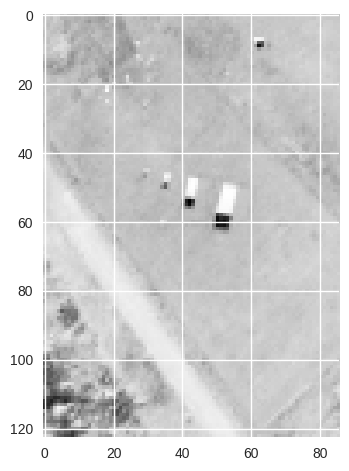

In [38]:
plt.imshow(data['X'][:,:,100].T)